In [1]:
import warnings
import time
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Data 

In [2]:
data = pd.read_csv('Global_Superstore2.csv', encoding = "latin-1")
data.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium


In [3]:
# Removing irrelevant columns
df = data.drop(['Row ID', 'Order ID', 'Ship Date', 'Customer ID', 'Customer Name',
              'Postal Code', 'Product ID', 'Product Name'], axis = 1)
# df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order Date      51290 non-null  object 
 1   Ship Mode       51290 non-null  object 
 2   Segment         51290 non-null  object 
 3   City            51290 non-null  object 
 4   State           51290 non-null  object 
 5   Country         51290 non-null  object 
 6   Market          51290 non-null  object 
 7   Region          51290 non-null  object 
 8   Category        51290 non-null  object 
 9   Sub-Category    51290 non-null  object 
 10  Sales           51290 non-null  float64
 11  Quantity        51290 non-null  int64  
 12  Discount        51290 non-null  float64
 13  Profit          51290 non-null  float64
 14  Shipping Cost   51290 non-null  float64
 15  Order Priority  51290 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 6.3+ MB


In [4]:
# Number of categories in each categorical variable

for i in df:
    if df[i].dtype == ('object' or 'category'):
        print(i, len(df[i].unique()))

Order Date 1430
Ship Mode 4
Segment 3
City 3636
State 1094
Country 147
Market 7
Region 13
Category 3
Sub-Category 17
Order Priority 4


### Monthly sales for all categories 

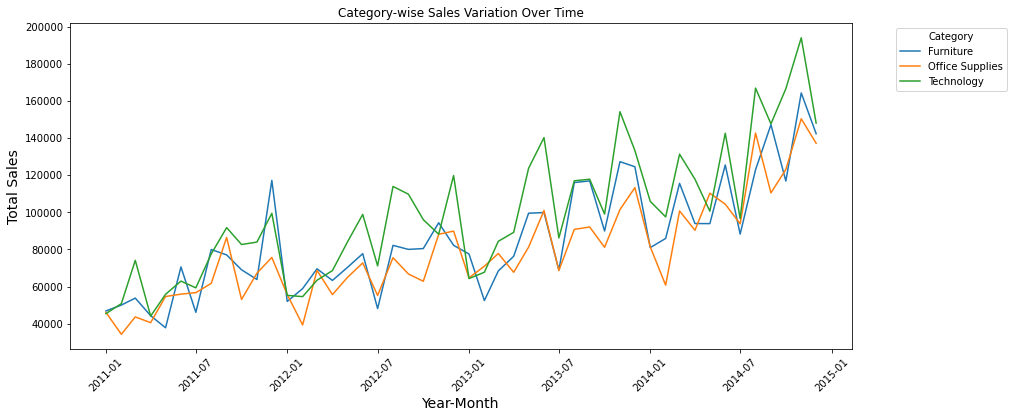

In [5]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['YearMonth'] = df['Order Date'].dt.to_period('M')  # setting to monthly steps

# Convert 'YearMonth' to timestamp
df['YearMonth'] = df['YearMonth'].dt.to_timestamp()

category_sales = df.groupby(['YearMonth', 'Category'])['Sales'].sum().reset_index()
sub_category_sales = df.groupby(['YearMonth', 'Category', 'Sub-Category'])['Sales'].sum().reset_index()

plt.figure(figsize = (14, 6))
sns.lineplot(x = 'YearMonth', y = 'Sales', hue = 'Category', data = category_sales, markers = True)
plt.title('Category-wise Sales Variation Over Time')
plt.xlabel('Year-Month', fontsize = 14)
plt.ylabel('Total Sales', fontsize = 14)
plt.xticks(rotation = 45)
plt.legend(title='Category', bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.show()

### Correlation among numerical features 

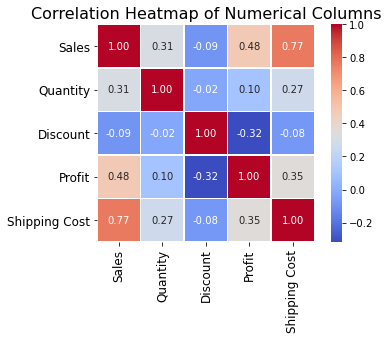

In [6]:
numerical_feat = ['Sales', 'Quantity', 'Discount', 'Profit', 'Shipping Cost']
numerical_df = df[numerical_feat]

correlation_matrix = numerical_df.corr()

plt.figure(figsize = (6, 4))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f", linewidths = .5, square = True)

plt.title('Correlation Heatmap of Numerical Columns', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()


## K-means clustering based on `sales` and `profit` for customer segmentation  
### WCSS method to obtain optimal number of clusters (k)

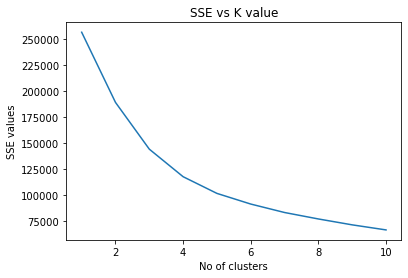

In [7]:
# Create a new DataFrame with selected features (all numerical)
customer_data = df[numerical_feat]

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data)

# WCSS method for finding the optimal k
sse = []
for k in range(1, 11):
    k_means = KMeans(n_clusters = k, n_init = 10)
    k_means.fit(scaled_data)  # Use fit instead of fit_predict
    sse.append(k_means.inertia_)
    
plt.plot(range(1, 11), sse)
plt.xlabel("No of clusters")
plt.ylabel("SSE values")
plt.title("SSE vs K value")
plt.show()

In [8]:
print(sse)

[256450.00000000047, 189076.63883923943, 144172.92890134623, 117711.56284474701, 101685.3022750602, 91451.66395723057, 83332.322779879, 77137.60743370492, 71477.65645670683, 66620.35533541226]


In [9]:
# Choose the number of clusters (K)
k = 4
kmeans = KMeans(n_clusters = k, random_state = 42)
df['Cluster'] = kmeans.fit_predict(scaled_data)

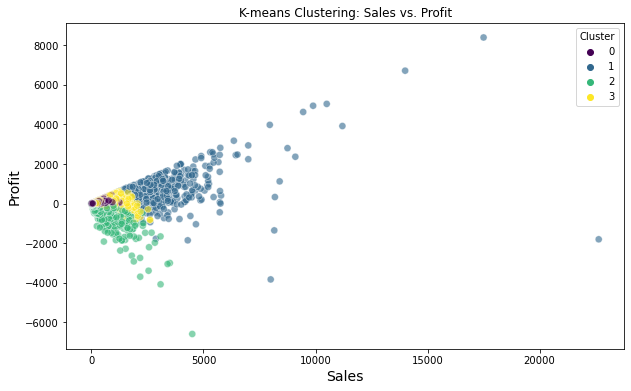

In [11]:
# Scatter plot for 'Sales' and 'Profit' colored by clusters
plt.figure(figsize = (10, 6))
sns.scatterplot(x = 'Sales', y = 'Profit', hue = 'Cluster', s = 50,
                data = df, palette = 'viridis', alpha = 0.6)
plt.title('K-means Clustering: Sales vs. Profit')
plt.xlabel('Sales', fontsize = 14)
plt.ylabel('Profit', fontsize = 14)
plt.show()

## Creating time series cross validation splits for each cluster  

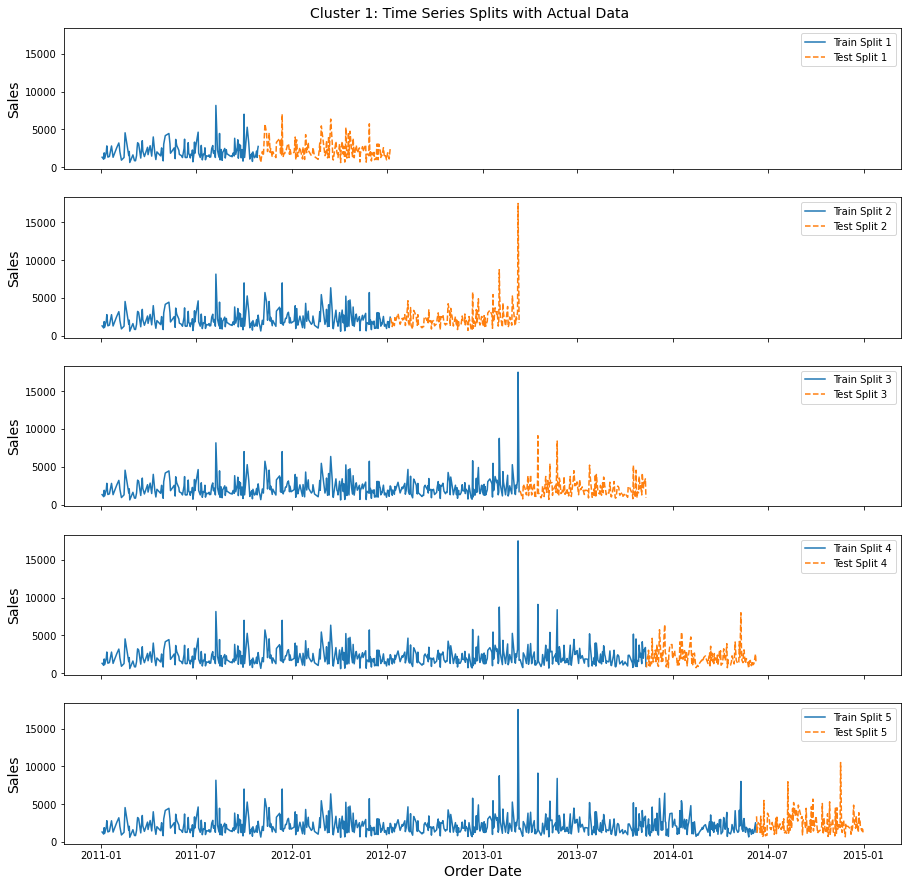

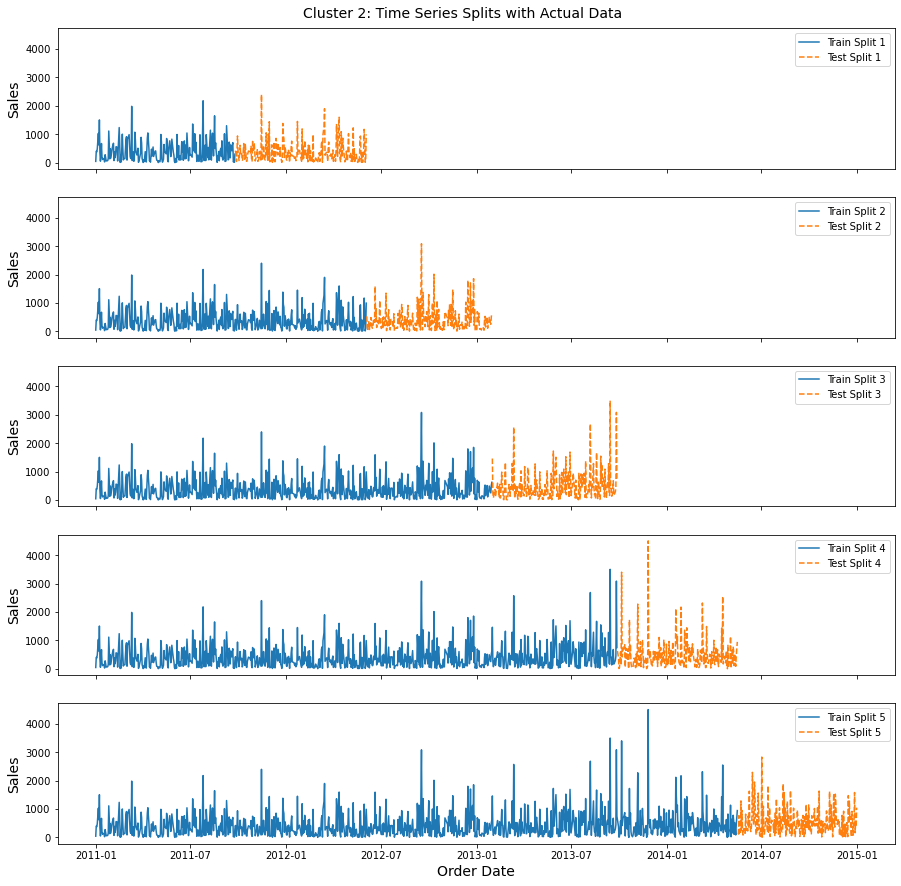

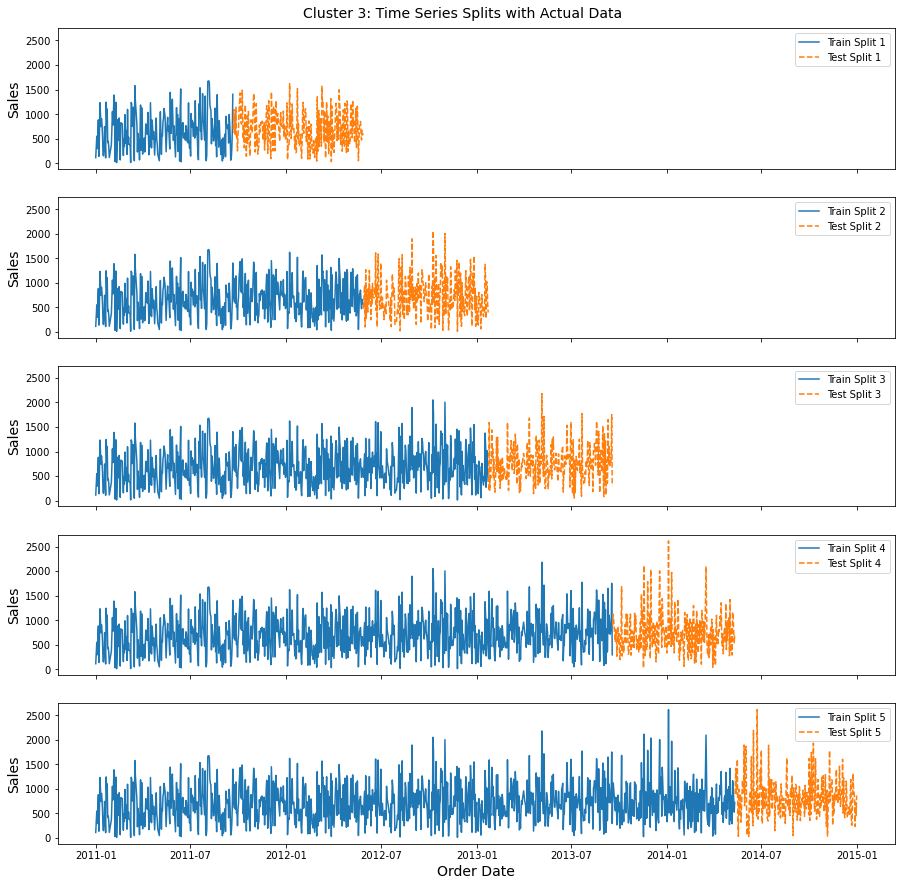

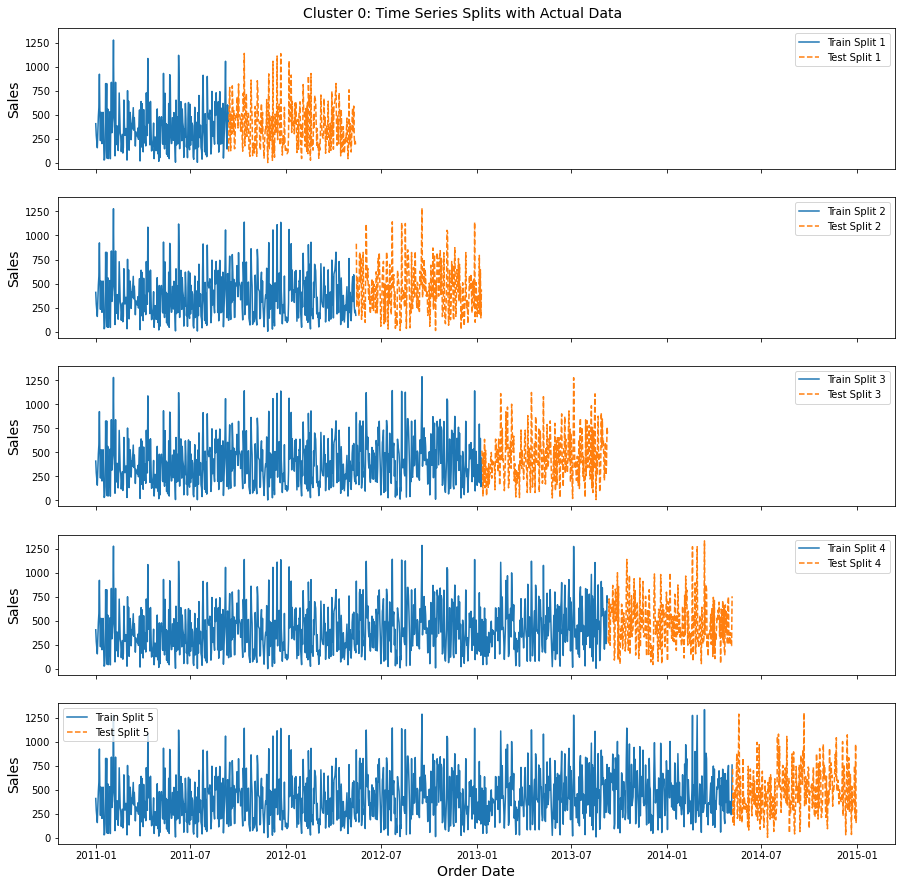

In [12]:
cluster_data = {}
cluster_models = {} 

for cluster_label in df['Cluster'].unique():    # Iterating over each cluster's data as obtained from k-means
    cluster_data[cluster_label] = df[df['Cluster'] == cluster_label].copy()

    label_encoder = LabelEncoder() 
    categorical_features = ["Ship Mode", "Segment", "Market", "Category", "Order Priority"] # Adding select categorical features
     
    for feature in categorical_features:        # Encoding the cateogrical features                                           
        cluster_data[cluster_label][f'{feature}_Encoded'] = label_encoder.fit_transform(
            cluster_data[cluster_label][feature])

    numerical_features = ["Sales", "Quantity", "Discount", "Profit", "Shipping Cost"]   
    encoded_features = [f'{feature}_Encoded' for feature in categorical_features]
    selected_features = numerical_features + encoded_features    # total features
    selected_features += ['Order Date']
    
    cluster_data[cluster_label] = cluster_data[cluster_label].groupby('Order Date').first().reset_index() #Grouping by each date
    
    X = cluster_data[cluster_label][selected_features[1:]]    # feature set
    y = cluster_data[cluster_label]['Sales']                  # target variable

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits = 5)

    fig, axes = plt.subplots(nrows = 5, ncols = 1, figsize = (15, 15), sharex = True, sharey = True)
    fig.suptitle(f'Cluster {cluster_label}: Time Series Splits with Actual Data', y = 0.9, fontsize = 14)

    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        ax = axes[i]

        ax.plot(
            cluster_data[cluster_label]['Order Date'].iloc[train_index],
            y.iloc[train_index],
            label = f'Train Split {i + 1}'
        )

        ax.plot(
            cluster_data[cluster_label]['Order Date'].iloc[test_index],
            y.iloc[test_index],
            label = f'Test Split {i + 1}',
            linestyle = 'dashed'
        )

        ax.set_ylabel('Sales', fontsize = 14)
        ax.legend()

    plt.xlabel('Order Date', fontsize = 14)
    plt.show()

## Predicting `Sales` for each cluster (customer segment) using XGBoost regression along with hyperparameter tuning

In [14]:
warnings.filterwarnings("ignore")

Best model parameters for cluster 1 are: {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 500}


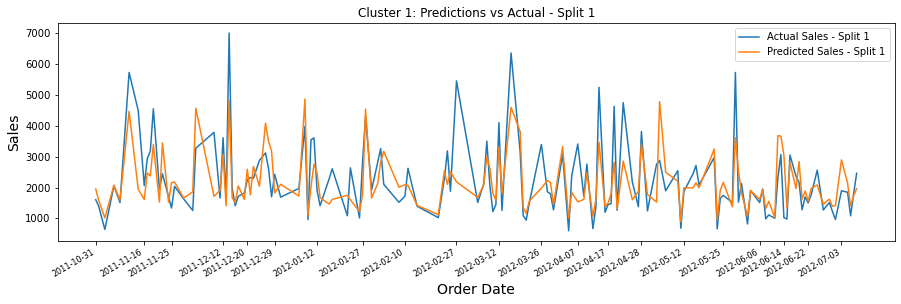

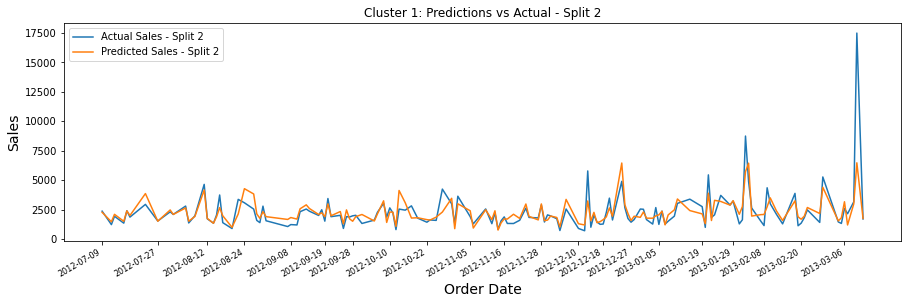

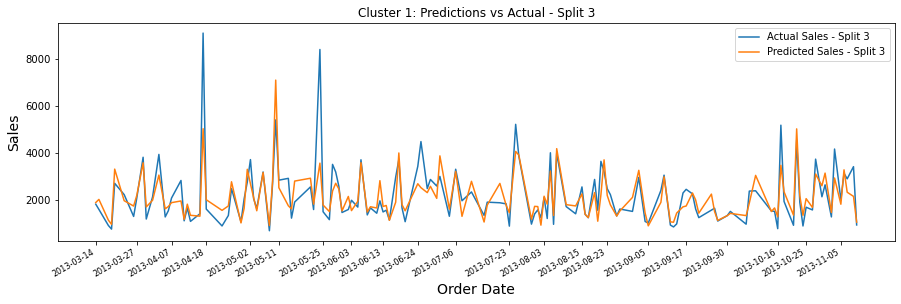

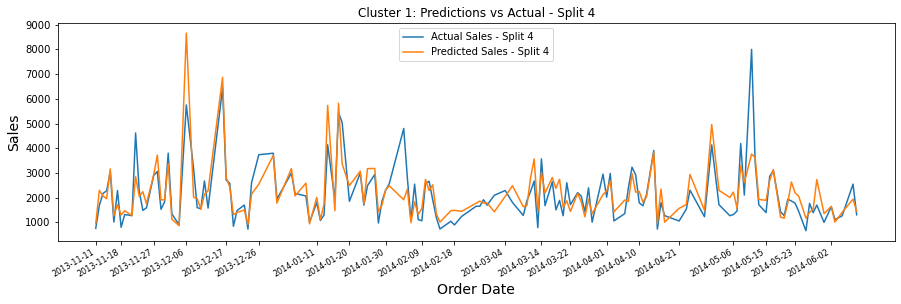

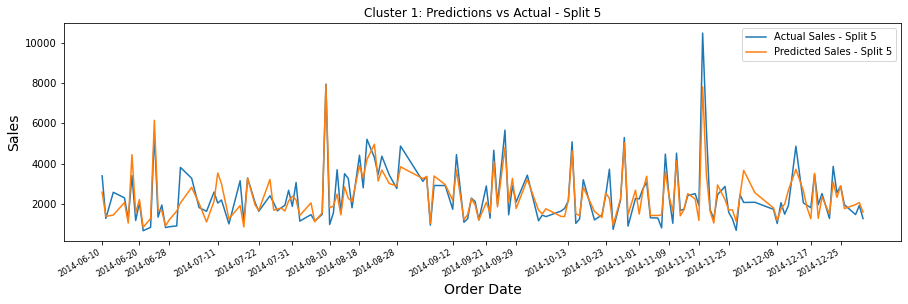

Average R-squared for cluster 1: 0.6348
Average RMSE for cluster 1: 805.2422

Best model parameters for cluster 2 are: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 1000}


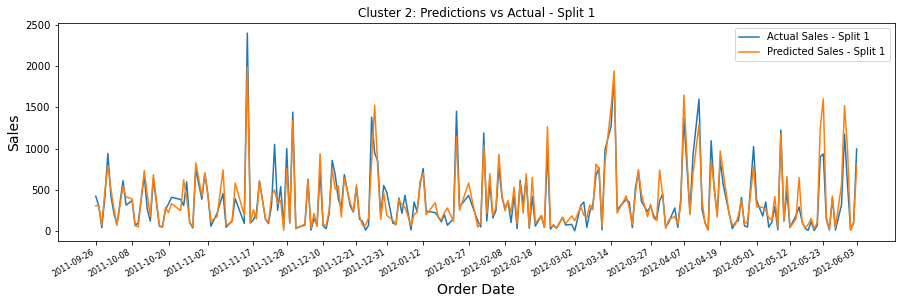

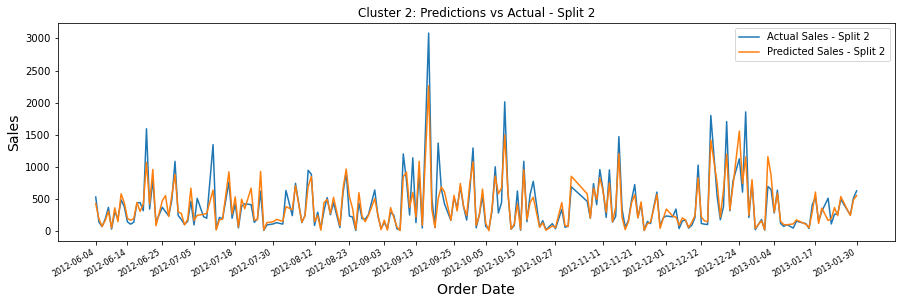

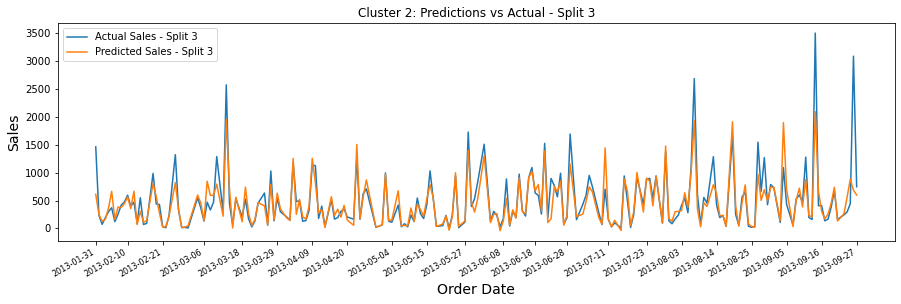

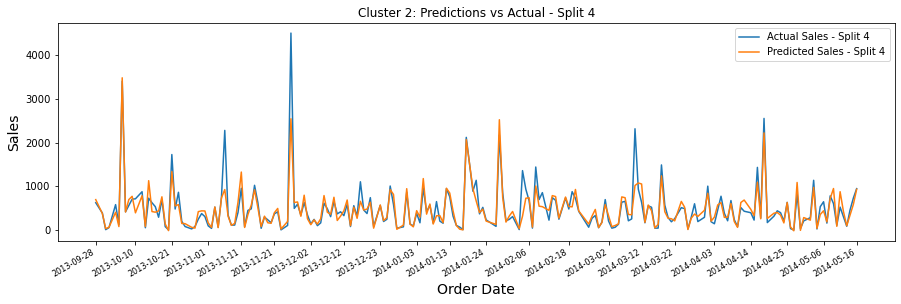

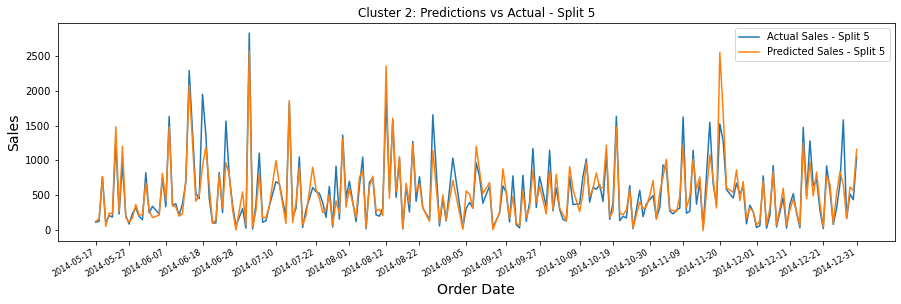

Average R-squared for cluster 2: 0.8116
Average RMSE for cluster 2: 204.98959999999997

Best model parameters for cluster 3 are: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100}


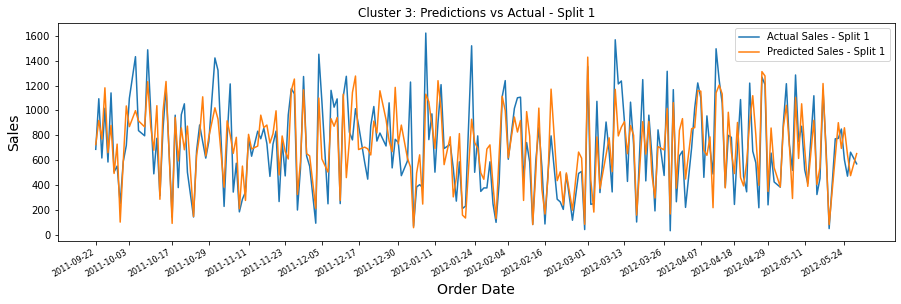

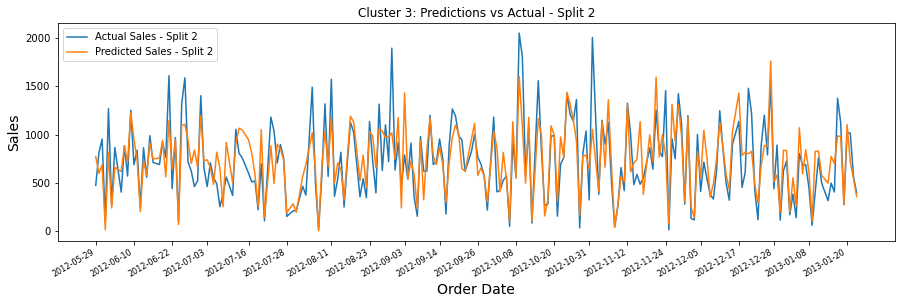

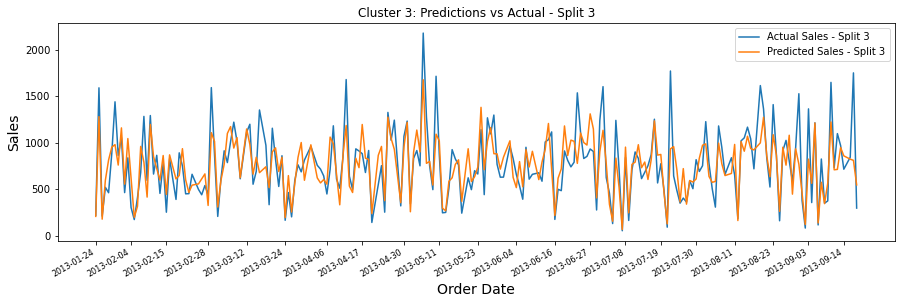

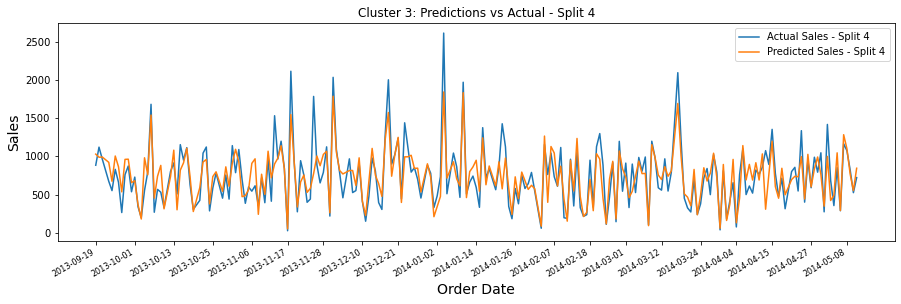

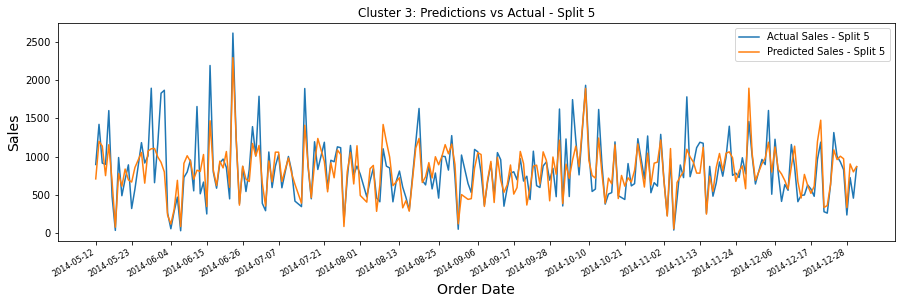

Average R-squared for cluster 3: 0.6574
Average RMSE for cluster 3: 229.0848

Best model parameters for cluster 0 are: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 1000}


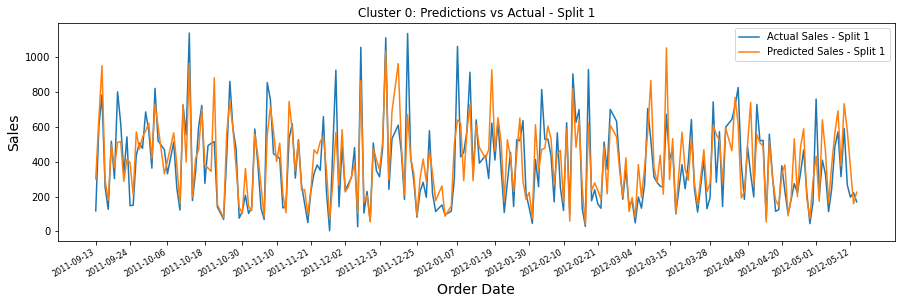

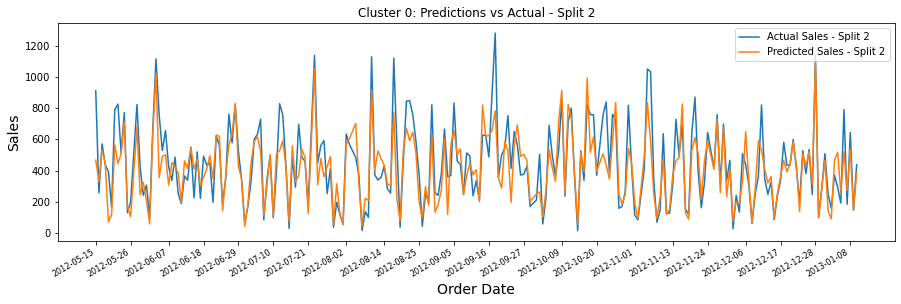

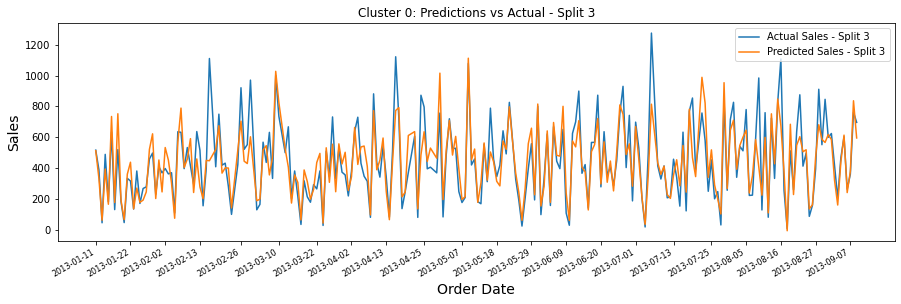

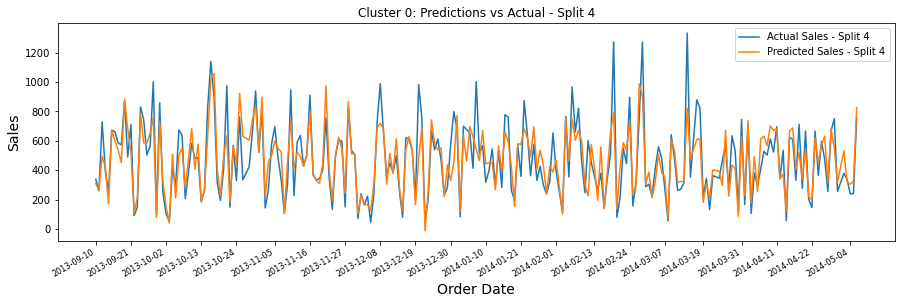

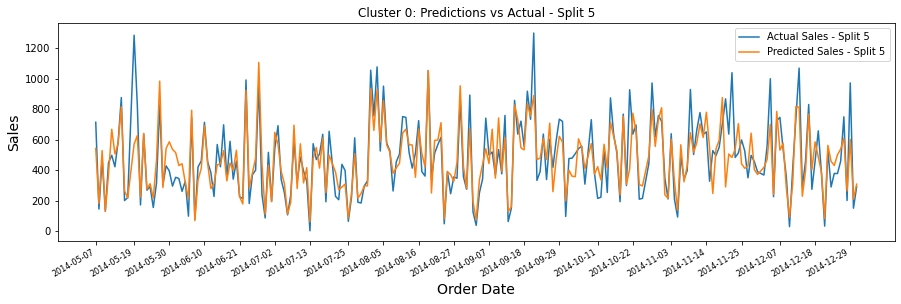

Average R-squared for cluster 0: 0.7158
Average RMSE for cluster 0: 134.1372

Time elapsed: 5.056660175323486 min


In [15]:
start = time.time()

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [1, 3, 5],
    'learning_rate': [0.001, 0.01, 0.1],
    'min_child_weight': [1, 3, 5]
}

for cluster_label in df['Cluster'].unique():
    cluster_data[cluster_label] = df[df['Cluster'] == cluster_label].copy()

    label_encoder = LabelEncoder()
    for feature in categorical_features:
        cluster_data[cluster_label][f'{feature}_Encoded'] = label_encoder.fit_transform(
            cluster_data[cluster_label][feature])

    numerical_features = ["Sales", "Quantity", "Discount", "Profit", "Shipping Cost"]
    encoded_features = [f'{feature}_Encoded' for feature in categorical_features]
    selected_features = numerical_features + encoded_features
    selected_features += ['Order Date']

    cluster_data[cluster_label] = cluster_data[cluster_label][selected_features]
    cluster_data[cluster_label] = cluster_data[cluster_label].groupby('Order Date').first().reset_index() # Grouping by each date

    x = cluster_data[cluster_label][selected_features[1 :]]  # feature set (excluding order date column)
    y = cluster_data[cluster_label]['Sales']  # target variable

    # Extract relevant information from 'Order Date' (feature engineering for time series)
    x['Order Date'] = pd.to_datetime(x['Order Date'])
    x['Year'] = x['Order Date'].dt.year
    x['Month'] = x['Order Date'].dt.month
    x['Day'] = x['Order Date'].dt.day
    x['DayOfWeek'] = x['Order Date'].dt.dayofweek

    X = x.drop(['Order Date'], axis = 1)

    # Initialize XGBoost model
    model = XGBRegressor()
    
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits = 5)

    # GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid, cv = tscv)
    grid_search.fit(X, y)

    # Obtaining the best parameters from the grid search
    best_params = grid_search.best_params_
    print(f"Best model parameters for cluster {cluster_label} are: {best_params}")

    # Train the model with the best parameters
    best_model = XGBRegressor(**best_params)

    avg_r2, avg_rmse = [], []

    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        best_model.fit(X_train, y_train)

        y_pred = best_model.predict(X_test)  # Predictions on test set (CV split)

        # Model evaluation
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        avg_r2.append(round(r2, 3))
        avg_rmse.append(round(math.sqrt(mse), 3))

        plt.figure(figsize = (15, 4))
        sorted_indices = x.iloc[test_index].index.argsort()  # Sorting based on the index
        sorted_dates = x.iloc[test_index]['Order Date'].iloc[sorted_indices]
        sorted_y_test = y_test.iloc[sorted_indices]
        sorted_y_pred = pd.Series(y_pred, index = sorted_dates)

        # Choose a subset of dates for plotting to avoid clutter
        subset_size = min(20, len(sorted_dates))
        step = len(sorted_dates) // subset_size
        subset_dates = sorted_dates.iloc[::step]

        plt.plot(sorted_dates, sorted_y_test, label = f'Actual Sales - Split {i + 1}')
        plt.plot(sorted_dates, sorted_y_pred, label = f'Predicted Sales - Split {i + 1}')
        plt.xticks(subset_dates, rotation = 30, ha = 'right')
        plt.title(f'Cluster {cluster_label}: Predictions vs Actual - Split {i + 1}')
        plt.xlabel('Order Date', fontsize = 14)
        plt.ylabel('Sales', fontsize = 14)
        plt.xticks(fontsize = 8)
        plt.legend()
        plt.show()

    print(f"Average R-squared for cluster {cluster_label}: {sum(avg_r2) / 5}")
    print(f"Average RMSE for cluster {cluster_label}: {sum(avg_rmse) / 5}")
    print("")

end = time.time()
print('Time elapsed:', (end - start) / 60, 'min')

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'Sales', y = 'Quantity', hue = 'Cluster', data = df, palette = 'viridis')
plt.title('K-means Clustering: Sales vs. Quantity')
plt.xlabel('Sales')
plt.ylabel('Quantity')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Profit', y='Quantity', hue='Cluster', data=df, palette='viridis')
plt.title('K-means Clustering: Profit vs. Quantity')
plt.xlabel('Profit')
plt.ylabel('Quantity')
plt.show()

In [ ]:
sampled_df = df.sample(frac=0.2)  # Adjust the fraction as needed
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Sales', y='Profit', hue='Cluster', data=sampled_df, palette='viridis')

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Sales', y='Profit', hue='Cluster', data=df, palette='viridis', s=50)  # Adjust 's' for marker size


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Sales'], df['Profit'], df['Quantity'], c=df['Cluster'], cmap='viridis')
ax.set_xlabel('Sales')
ax.set_ylabel('Profit')
ax.set_zlabel('Quantity', labelpad=25)  # Adjust labelpad to move the label away from the data points

plt.show()

In [ ]:
c1 = df[df['Cluster'] == 0]
c2 = df[df['Cluster'] == 1]
c3 = df[df['Cluster'] == 2]
c4 = df[df['Cluster'] == 3]

In [ ]:
print(c1.shape,c2.shape,c3.shape,c4.shape)

In [ ]:
cluster_summary = df.groupby('Cluster').mean()
print(cluster_summary)


In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Cluster', y='Sales', data=sampled_df)
plt.title('Sales Distribution Across Clusters')


In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Cluster', y='Profit', data=sampled_df)
plt.title('Sales Distribution Across Clusters')

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Cluster', y='Quantity', data=sampled_df)
plt.title('Sales Distribution Across Clusters')

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Cluster', y='Discount', data=sampled_df)
plt.title('Sales Distribution Across Clusters')

In [ ]:
###Now decision trees
df['Cluster'].unique()

In [ ]:
features1 = ['Order Date', 'Ship Mode', 'Segment', 'City', 'State', 'Country', 'Market', 'Region', 'Category', 'Sub-Category', 'Sales', 'Quantity', 'Discount', 'Profit', 'Shipping Cost', 'Order Priority']
X = df[features1]
